---
<h1 align="center"><strong>Semantic Similarity CamemBERT + (Bi)LSTM</strong><h1>

<h2 align="center"><b>---Bi-Encoder---<h2>

---

In [ ]:
!pip install transformers -q
!pip install SentencePiece -q
!pip install datasets -q

     |████████████████████████████████| 4.4 MB 8.9 MB/s 
     |████████████████████████████████| 596 kB 43.2 MB/s 
     |████████████████████████████████| 6.6 MB 26.6 MB/s 
     |████████████████████████████████| 101 kB 11.0 MB/s 
     |████████████████████████████████| 1.2 MB 8.4 MB/s 
     |████████████████████████████████| 362 kB 6.6 MB/s 
     |████████████████████████████████| 212 kB 29.8 MB/s 
     |████████████████████████████████| 140 kB 34.7 MB/s 
     |████████████████████████████████| 1.1 MB 40.5 MB/s 
     |████████████████████████████████| 127 kB 35.0 MB/s 
     |████████████████████████████████| 271 kB 35.4 MB/s 
     |████████████████████████████████| 94 kB 2.3 MB/s 
     |████████████████████████████████| 144 kB 42.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which i

### Required libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn import model_selection, metrics

from tqdm import tqdm
from collections import defaultdict

import warnings
warnings.filterwarnings("ignore")
import scipy

### Utils

In [ ]:
def convert_dataset(dataset):
  dataset_samples= pd.DataFrame(columns = ["sentence1","sentence2", "similarity_score"])
  for df in dataset:
    score = float(df['similarity_score'])/5.0
    dataset_samples = dataset_samples.append(df, ignore_index = True)
  dataset_samples['similarity_score']= dataset_samples.apply(lambda col: float(col.similarity_score)/5.0, axis=1)
  return dataset_samples

def get_sts_df(df_train, df_valid, df_test):
  train_samples = convert_dataset(df_train)
  dev_samples = convert_dataset(df_valid)
  test_samples = convert_dataset(df_test)

  df = pd.concat([train_samples, dev_samples], axis=0)
  df.reset_index(drop=True, inplace=True)
  #df["similarity_score"] = df["similarity_score"].apply(lambda score: 1 if score> 0.5 else 0)
  return df, test_samples

In [ ]:
df_train = load_dataset("stsb_multi_mt", name="fr", split="train")
df_valid = load_dataset("stsb_multi_mt", name="fr", split="dev")
df_test = load_dataset("stsb_multi_mt", name="fr", split="test")

df, test_samples = get_sts_df(df_train, df_valid, df_test)
df.to_csv("sts.csv")

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Dataset stsb_multi_mt downloaded and prepared to /root/.cache/huggingface/datasets/stsb_multi_mt/fr/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9. Subsequent calls will reuse this data.


Reusing dataset stsb_multi_mt (/root/.cache/huggingface/datasets/stsb_multi_mt/fr/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)
Reusing dataset stsb_multi_mt (/root/.cache/huggingface/datasets/stsb_multi_mt/fr/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)


In [ ]:
class Config:
  MAX_LEN = 64
  TRAIN_BATCH_SIZE = 8
  VALID_BATCH_SIZE = 4
  EPOCHS = 2
  DEVICE = torch.device("cuda") #if torch.cuda.is_available() else "cpu")

  CamemeBERT_PATH = "camembert-base"
  MODEL_PATH_LSTM = "stscamembertLstmModel.bin"
  MODEL_PATH_BiLSTM = "stscamembertBiLstmModel.bin"


  TRAINING_DATA = "sts.csv"

  TOKENIZER = transformers.CamembertTokenizer.from_pretrained(CamemeBERT_PATH, do_lower_case = True)
  MODEL = transformers.CamembertModel.from_pretrained(CamemeBERT_PATH, return_dict=False)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Dataset

In [ ]:
class DataProcess:
  def __init__(self, sent1, sent2):
    self.tokenizer = Config.TOKENIZER
    self.max_len = Config.MAX_LEN

    self.sent1 = sent1
    self.sent2 = sent2
    
  def preprocess_bert(self):
    sent1 = " ".join(self.sent1.split())
    sent2 = " ".join(self.sent2.split())

    inputs1 = self.tokenizer.encode_plus(
        sent1,
        None,
        add_special_tokens=True,
        max_length=self.max_len,
        # padding = "max_length",
        truncation=True
        )
    
    inputs2 = self.tokenizer.encode_plus(
        sent2,
        None,
        add_special_tokens=True,
        max_length=self.max_len,
        # padding = "max_length",
        truncation=True
        )

    input_ids1 = inputs1["input_ids"]
    attention_mask1 = inputs1["attention_mask"]

    input_ids2 = inputs2["input_ids"]
    attention_mask2 = inputs2["attention_mask"]

    return (
        torch.tensor(input_ids1, dtype=torch.long).unsqueeze(0),
        torch.tensor(attention_mask1, dtype=torch.long).unsqueeze(0),
        torch.tensor(input_ids2, dtype=torch.long).unsqueeze(0),
        torch.tensor(attention_mask2, dtype=torch.long).unsqueeze(0)
        )
    
  def preprocess_output(self, outputs):
    outputs = outputs.cpu().detach().numpy()
    return outputs


class STS:
  def __init__(self,  sent1, sent2, label):
    self.sent1 = sent1
    self.sent2 = sent2
    
    self.label = label
    self.max_len = Config.MAX_LEN
    self.tokenizer = Config.TOKENIZER
  
  def __len__(self):
    return len(self.sent1)
  
  def __getitem__(self, item):
    sent1 = str(self.sent1[item])
    sent1 = " ".join(sent1.split())

    sent2 = str(self.sent2[item])
    sent2 = " ".join(sent2.split())

    inputs1 = self.tokenizer.encode_plus(
        sent1,
        None,
        add_special_tokens=True,
        max_length=self.max_len,
        padding="max_length",
        truncation=True
    )

    inputs2 = self.tokenizer.encode_plus(
        sent2,
        None,
        add_special_tokens=True,
        max_length=self.max_len,
        padding="max_length",
        truncation=True
    )

    input_ids1 = inputs1["input_ids"]
    attention_mask1 = inputs1["attention_mask"]

    input_ids2 = inputs2["input_ids"]
    attention_mask2 = inputs2["attention_mask"]

    return {
        "input_ids1" : torch.tensor(input_ids1, dtype=torch.long),
        "attention_mask1" : torch.tensor(attention_mask1, dtype=torch.long),
        "input_ids2" : torch.tensor(input_ids2, dtype=torch.long),
        "attention_mask2" : torch.tensor(attention_mask2, dtype=torch.long),
        "labels" : torch.tensor(self.label[item], dtype=torch.float)
    }

### Bi-Encode Model

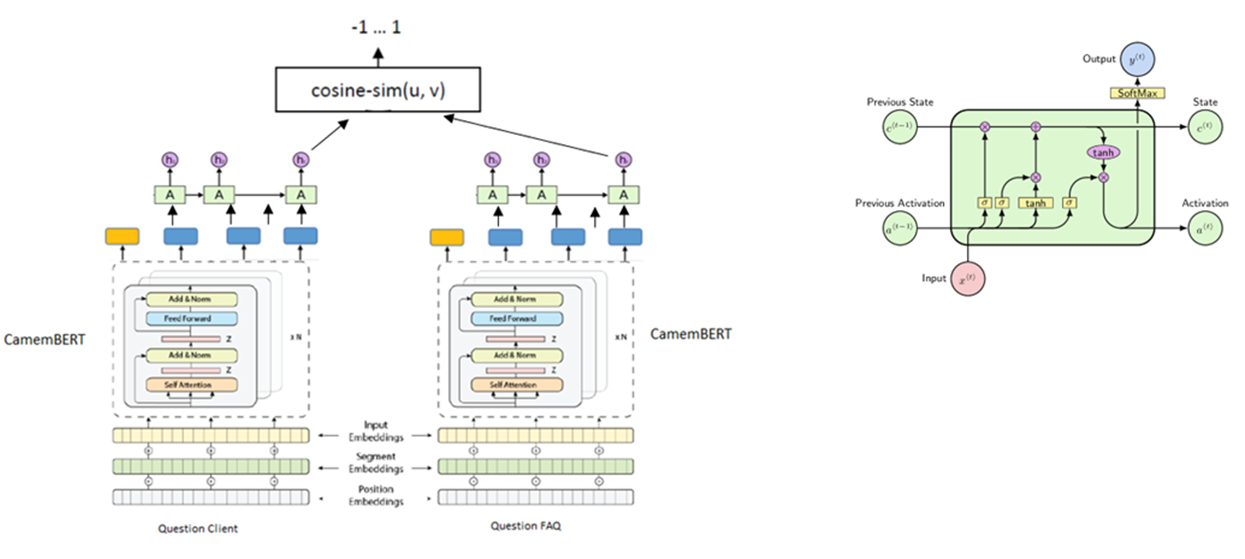

## Bi Encoder : Camembert + LSTM 

In [ ]:
class CamemBERTLstmModel(nn.Module):
  def __init__(self):
    super(CamemBERTLstmModel, self).__init__()
    self.camembert = Config.MODEL
    # Add LSTM on top of BERT
    self.lstm = nn.LSTM(768, 256, batch_first=True) 
    # Add Dropout
    self.camembert_drop = nn.Dropout(0.3)    

  def forward(self, input_ids, attention_mask):
    sequence_output, pooled_output = self.camembert(input_ids=input_ids, attention_mask=attention_mask)
    out_lstm, (h,c) = self.lstm(sequence_output)
    output = self.camembert_drop(out_lstm[:,-1].view(-1, 256))

    return output

In [ ]:
class SiameseCamemBERTLstm(nn.Module):
    def __init__(self):
        super(SiameseCamemBERTLstm, self).__init__()

        self.encoder = CamemBERTLstmModel()
        self.cos = nn.CosineSimilarity(dim=1)

    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2):
        # input one by one        
      sent1 = self.encoder(input_ids=input_ids1, attention_mask=attention_mask1)
      sent2 = self.encoder(input_ids=input_ids2, attention_mask=attention_mask2)
  
      output = self.cos(sent1, sent2)

      return output

### Engine

In [ ]:
def loss_fn(outputs, labels):
  return nn.MSELoss()(outputs, labels.view(-1, 1))

def train_fn(train_dataloader, model, optimizer, device, scheduler):
  model.train()
  final_loss = 0

  fin_labels = []
  fin_outputs = []
  for bi, d in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    input_ids1 = d["input_ids1"]
    attention_mask1 = d["attention_mask1"]
    input_ids2 = d["input_ids2"]
    attention_mask2 = d["attention_mask2"]
    labels = d["labels"]

    input_ids1 = input_ids1.to(device, dtype=torch.long)
    attention_mask1 = attention_mask1.to(device, dtype=torch.long)
    input_ids2 = input_ids2.to(device, dtype=torch.long)
    attention_mask2 = attention_mask2.to(device, dtype=torch.long)
    labels = labels.to(device, dtype = torch.float)

    optimizer.zero_grad()
    outputs = model(input_ids1=input_ids1, attention_mask1=attention_mask1, input_ids2=input_ids2, attention_mask2=attention_mask2)
    loss = loss_fn(outputs, labels)
    
    final_loss += loss.item()
    fin_labels.extend(labels.cpu().detach().numpy().tolist())
    fin_outputs.extend(outputs.cpu().detach().numpy().tolist())
    
    loss.backward()
    optimizer.step()
    scheduler.step()

  return fin_outputs, fin_labels, final_loss/len(train_dataloader)

def eval_fn(valid_dataloader, model, device):
  model.eval()
  final_loss = 0

  fin_labels = []
  fin_outputs = []
  with torch.no_grad():
    for bi, d in tqdm(enumerate(valid_dataloader), total=len(valid_dataloader)):
      input_ids1 = d["input_ids1"]
      attention_mask1 = d["attention_mask1"]
      input_ids2 = d["input_ids2"]
      attention_mask2 = d["attention_mask2"]
      labels = d["labels"]

      input_ids1 = input_ids1.to(device, dtype=torch.long)
      attention_mask1 = attention_mask1.to(device, dtype=torch.long)
      input_ids2 = input_ids2.to(device, dtype=torch.long)
      attention_mask2 = attention_mask2.to(device, dtype=torch.long)
      labels = labels.to(device, dtype = torch.float)

      outputs = model(input_ids1=input_ids1, attention_mask1=attention_mask1, input_ids2=input_ids2, attention_mask2=attention_mask2)
      
      loss = loss_fn(outputs, labels)
      final_loss += loss.item()
      
      fin_labels.extend(labels.cpu().detach().numpy().tolist())
      fin_outputs.extend(outputs.cpu().detach().numpy().tolist())
      

  return fin_outputs, fin_labels, final_loss/len(valid_dataloader)

### Train

In [ ]:
df_train = pd.read_csv(Config.TRAINING_DATA).fillna("none")
df_valid = test_samples

'''df_train, df_valid = model_selection.train_test_split(
    dfx, test_size=0.1, random_state=42) #stratify=dfx.similarity_score.values'''
    

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

train_dataset = STS(
    sent1=df_train.sentence1.values, 
    sent2=df_train.sentence2.values, 
    label=df_train.similarity_score.values
)
train_dataloader = DataLoader(train_dataset, batch_size=Config.TRAIN_BATCH_SIZE, num_workers=4)

valid_dataset = STS(
    sent1=df_valid.sentence1.values, 
    sent2=df_valid.sentence2.values, 
    label=df_valid.similarity_score.values
)
valid_dataloader = DataLoader(valid_dataset, batch_size=Config.VALID_BATCH_SIZE, num_workers=1)

model = SiameseCamemBERTLstm()
model.to(Config.DEVICE)

# Optimizer
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
                        {
                            "params": [
                                       p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                                       ],
                         "weight_decay": 0.001,
                         },
                        {
                            "params": [
                                       p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                                       ],
                         "weight_decay": 0.0,
                         },
                        ]


optimizer = AdamW(optimizer_parameters, lr=3e-5)

num_train_steps = int(len(df_train) / Config.TRAIN_BATCH_SIZE * Config.EPOCHS)

'''optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  correct_bias = False) # We chose to correct bias'''
                  
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
    )

In [ ]:
history = defaultdict(list)
best_accuracy_valid = 0
for epoch in range(1, 4):
  train_outputs, train_labels, train_loss = train_fn(train_dataloader, model, optimizer, Config.DEVICE, scheduler)
  valid_outputs, valid_labels, valid_loss = eval_fn(valid_dataloader, model, Config.DEVICE)  

  #train_r2score = metrics.r2_score(train_labels, train_outputs)
  #valid_r2score = metrics.r2_score(valid_labels, valid_outputs)

  train_pearson_corr = scipy.stats.pearsonr(train_labels, train_outputs)[0]
  valid_pearson_corr= scipy.stats.pearsonr(valid_labels, valid_outputs)[0]

  print(f"Epoch: {epoch}\nTrain Loss: {train_loss} - Train pearson Correlation: {train_pearson_corr} \nValid Loss: {valid_loss}  - Valid pearson Correlation: {valid_pearson_corr}\n")
  
  history['Train Loss'].append(train_loss)

  history['Valid Loss'].append(valid_loss)

  history['Train Pearson correlation'].append(train_pearson_corr)
  history['Valid Pearson correlation'].append(valid_pearson_corr)

  if best_accuracy_valid < valid_pearson_corr :
      torch.save(model.state_dict(), Config.MODEL_PATH_LSTM)
      best_accuracy_valid = valid_pearson_corr



100%|██████████| 345/345 [00:12<00:00, 26.79it/s]


Epoch: 1
Train Loss: 0.08530152709528295 - Train pearson Correlation: 0.4691111692223537 
Valid Loss: 0.17274427921983643  - Valid pearson Correlation: 0.7098103101271094



100%|██████████| 345/345 [00:12<00:00, 26.91it/s]


Epoch: 2
Train Loss: 0.08230369752057332 - Train pearson Correlation: 0.556386761279526 
Valid Loss: 0.14310586448434903  - Valid pearson Correlation: 0.7301806637301089



100%|██████████| 345/345 [00:12<00:00, 27.10it/s]

Epoch: 3
Train Loss: 0.08412067153282636 - Train pearson Correlation: 0.6454964598749268 
Valid Loss: 0.14310586448434903  - Valid pearson Correlation: 0.7301806637301089



### Error Analysis & Performance auditing

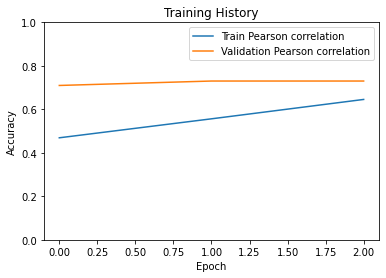

In [ ]:
plt.plot(history['Train Pearson correlation'], label='Train Pearson correlation')
plt.plot(history['Valid Pearson correlation'], label='Validation Pearson correlation')
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

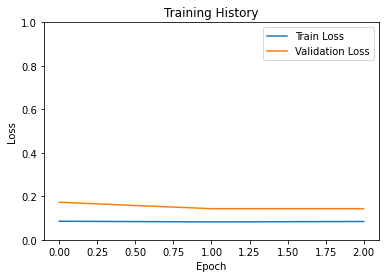

In [ ]:
plt.plot(history['Train Loss'], label='Train Loss')
plt.plot(history['Valid Loss'], label='Validation Loss')
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Inference

In [ ]:
model_lstm = SiameseCamemBERTLstm()
model_lstm.to(Config.DEVICE)
model_lstm.load_state_dict(
    torch.load(
        Config.MODEL_PATH_LSTM,
        map_location=torch.device(Config.DEVICE)
        )
    )

def predict(sent1: str, sent2: str):
  data = DataProcess(sent1, sent2)
  input_ids1, attention_mask1, input_ids2, attention_mask2 = data.preprocess_bert()
  
  input_ids1 = input_ids1.to(Config.DEVICE, dtype=torch.long)
  attention_mask1 = attention_mask1.to(Config.DEVICE, dtype=torch.long)
  input_ids2 = input_ids2.to(Config.DEVICE, dtype=torch.long)
  attention_mask2 = attention_mask2.to(Config.DEVICE, dtype=torch.long)
  
  outputs = model_lstm(input_ids1, attention_mask1, input_ids2, attention_mask2)
  similarity_score = data.preprocess_output(outputs) 
  
  return {
      "sentence1": sent1,
      "sentence2": sent2,
      "similarity Score": str(similarity_score)
      #"no similarity Score": str(no_similarity_Score),
  }

In [ ]:
sentence1 = "Trois hommes jouent aux échecs."
sentence2 = "Deux hommes jouent aux échecs."

similarity_score = predict(sentence1, sentence2)
print(similarity_score)

{'sentence1': 'Trois hommes jouent aux échecs.', 'sentence2': 'Deux hommes jouent aux échecs.', 'similarity Score': '[0.8186658]'}


In [ ]:
sentence1 = "je suis heureux"
sentence2 = "je suis triste"

similarity_score = predict(sentence1, sentence2)
print(similarity_score)

{'sentence1': 'je suis heureux', 'sentence2': 'je suis triste', 'similarity Score': '[0.6744134]'}


Inference : FAQ CMR

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
faq = pd.read_excel('/content/drive/MyDrive/FAQ-CMR.xlsx')
faq.head()

,Question,Réponse,Catégorie
0,"Je suis un fonctionnaire, comment m’affilier a...",Vous n'avez aucune démarche à faire pour cette...,Affiliation
1,J’étais un agent dans une collectivité territo...,"Oui, toutefois, vous devez informer votre Adm...",Affiliation
2,La date de naissance portée sur mon attestatio...,"En cas de discordance, merci de contacter votr...",Affiliation
3,Quelles sont les conditions nécessaires pour l...,Tous les affiliés aux régimes de base de gérés...,Attakmili
4,Quel est la cotisation minimale au titre du Ré...,La cotisation minimale est de 50 DHS,Attakmili


In [ ]:
query = "est ce qu'il y a une possibilté pour changer le nom ?"

def predict_(sent1: str, sent2: str):
  data = DataProcess(sent1, sent2)
  input_ids1, attention_mask1, input_ids2, attention_mask2 = data.preprocess_bert()
  
  input_ids1 = input_ids1.to(Config.DEVICE, dtype=torch.long)
  attention_mask1 = attention_mask1.to(Config.DEVICE, dtype=torch.long)
  input_ids2 = input_ids2.to(Config.DEVICE, dtype=torch.long)
  attention_mask2 = attention_mask2.to(Config.DEVICE, dtype=torch.long)
  
  outputs = model_lstm(input_ids1, attention_mask1, input_ids2, attention_mask2)
  similarity_score = data.preprocess_output(outputs)
  return similarity_score

question=[]
scores = []
for idx in range(faq.shape[0]):
  score = predict_(query,str(faq['Question'][idx]))[0]
  scores.append(score)
  question.append(faq['Question'][idx])
  


In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [ ]:
df = pd.DataFrame(list(zip(question, scores)),
               columns =['Question', 'similarity_score'])
df.sort_values(by='similarity_score', axis=0, ascending=False).head(5)

,Question,similarity_score
28,Comment faut-il procéder pour rectifier mon nom?,0.669343
29,Comment faut-il procéder pour changer mon nom ?,0.635506
77,Faut-il envoyer les documents relatifs au contrôle de maintien de droit d’une manière automatique à la CMR ?,0.634964
7,"J'ai une période creuse durant laquelle j'ai cessé de cotiser au titre d’Attakmili, est ce que je peux la racheter ?",0.613131
13,"Je suis un ayant droit d’un retraité décédé avant de demander la validation de ses services, est ce que j’ai le droit de déposer une demande à ce sujet auprès de la CMR ?",0.605329


## CamemBERT + BILSTM

In [ ]:
class CamemBERTBilstmModel(nn.Module):
  def __init__(self):
    super(CamemBERTBilstmModel, self).__init__()
    self.camembert = Config.MODEL
    # Add LSTM on top of BERT
    self.bilstm = nn.LSTM(768, 256, batch_first=True, bidirectional=True)
    # Add dropout
    self.camembert_drop = nn.Dropout(0.2)

  def forward(self, input_ids, attention_mask):
    sequence_output, pooled_output = self.camembert(input_ids=input_ids, attention_mask=attention_mask)
    out_lstm, (h,c) = self.bilstm(sequence_output)
    output = self.camembert_drop(out_lstm[:,-1].view(-1, 256*2))

    return output

In [ ]:
class SiameseCamemBERTBiLstm(nn.Module):
    def __init__(self):
        super(SiameseCamemBERTBiLstm, self).__init__()

        self.encoder = CamemBERTLstmModel()
        self.cos = nn.CosineSimilarity(dim=1)

    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2):
        # input one by one        
      sent1 = self.encoder(input_ids=input_ids1, attention_mask=attention_mask1)
      sent2 = self.encoder(input_ids=input_ids2, attention_mask=attention_mask2)
  
      output = self.cos(sent1, sent2)

      return output

## **Train**

In [ ]:
df_train = pd.read_csv(Config.TRAINING_DATA).fillna("none")
df_valid = test_samples

'''df_train, df_valid = model_selection.train_test_split(
    dfx, test_size=0.1, random_state=42) #stratify=dfx.similarity_score.values'''
    

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

train_dataset = STS(
    sent1=df_train.sentence1.values, 
    sent2=df_train.sentence2.values, 
    label=df_train.similarity_score.values
)
train_dataloader = DataLoader(train_dataset, batch_size=Config.TRAIN_BATCH_SIZE, num_workers=4)

valid_dataset = STS(
    sent1=df_valid.sentence1.values, 
    sent2=df_valid.sentence2.values, 
    label=df_valid.similarity_score.values
)
valid_dataloader = DataLoader(valid_dataset, batch_size=Config.VALID_BATCH_SIZE, num_workers=1)

model_bilstm = SiameseCamemBERTBiLstm()
model_bilstm.to(Config.DEVICE)

# Optimizer
param_optimizer = list(model_bilstm.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
                        {
                            "params": [
                                       p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                                       ],
                         "weight_decay": 0.001,
                         },
                        {
                            "params": [
                                       p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                                       ],
                         "weight_decay": 0.0,
                         },
                        ]


optimizer = AdamW(optimizer_parameters, lr=3e-5)

num_train_steps = int(len(df_train) / Config.TRAIN_BATCH_SIZE * Config.EPOCHS)

'''optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  correct_bias = False) # We chose to correct bias'''
                  
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
    )

In [ ]:
history_bilstm = defaultdict(list)
best_accuracy_valid = 0

for epoch in range(1, 3):
  train_outputs, train_labels, train_loss = train_fn(train_dataloader, model_bilstm, optimizer, Config.DEVICE, scheduler)
  valid_outputs, valid_labels, valid_loss = eval_fn(valid_dataloader, model_bilstm, Config.DEVICE)
  

  train_r2score = metrics.r2_score(train_labels, train_outputs)
  valid_r2score = metrics.r2_score(valid_labels, valid_outputs)

  train_pearson_corr = scipy.stats.pearsonr(train_labels, train_outputs)[0]
  valid_pearson_corr= scipy.stats.pearsonr(valid_labels, valid_outputs)[0]

  print(f"Epoch: {epoch}\nTrain Loss: {train_loss} - Train r2_score: {train_r2score} - Train pearson Correlation: {train_pearson_corr} \nValid Loss: {valid_loss} - Valid r2_score: {valid_r2score} - Valid pearson Correlation: {valid_pearson_corr}\n")
  
  history_bilstm['Train Loss'].append(train_loss)
  history_bilstm['Train Accuracy'].append(train_r2score)
  history_bilstm['Valid Loss'].append(valid_loss)
  history_bilstm['Valid Accuracy'].append(valid_r2score)
  history_bilstm['Train Pearson correlation'].append(train_pearson_corr)
  history_bilstm['Valid Pearson correlation'].append(valid_pearson_corr)

  if best_accuracy_valid < valid_pearson_corr :
      torch.save(model_bilstm.state_dict(), Config.MODEL_PATH_BiLSTM)
      best_accuracy_valid = valid_pearson_corr



100%|██████████| 345/345 [00:09<00:00, 35.26it/s]


Epoch: 1
Train Loss: 0.08544703213089323 - Train r2_score: 0.1943781300561721 - Train pearson Correlation: 0.44746514388564274 
Valid Loss: 0.12752185633972934 - Valid r2_score: 0.01929772521576234 - Valid pearson Correlation: 0.6484761959535482



100%|██████████| 345/345 [00:09<00:00, 35.24it/s]


Epoch: 2
Train Loss: 0.08283309724547437 - Train r2_score: 0.2364902481216956 - Train pearson Correlation: 0.5040011974936497 
Valid Loss: 0.11884543801644358 - Valid r2_score: 0.1577083270463272 - Valid pearson Correlation: 0.6636124020597113



### Error Analysis & Performance auditing

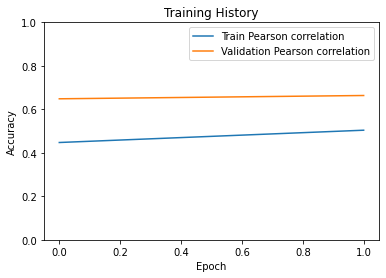

In [ ]:
plt.plot(history_bilstm['Train Pearson correlation'], label='Train Pearson correlation')
plt.plot(history_bilstm['Valid Pearson correlation'], label='Validation Pearson correlation')
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

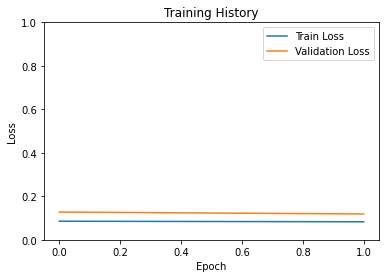

In [ ]:
plt.plot(history_bilstm['Train Loss'], label='Train Loss')
plt.plot(history_bilstm['Valid Loss'], label='Validation Loss')
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Inference

In [ ]:
model_bilstm = SiameseCamemBERTBiLstm()
model_bilstm.to(Config.DEVICE)
model_bilstm.load_state_dict(
    torch.load(
        Config.MODEL_PATH_BiLSTM,
        map_location=torch.device(Config.DEVICE)
        )
    )

def predict(sent1: str, sent2: str):
  data = DataProcess(sent1, sent2)
  input_ids1, attention_mask1, input_ids2, attention_mask2 = data.preprocess_bert()
  
  input_ids1 = input_ids1.to(Config.DEVICE, dtype=torch.long)
  attention_mask1 = attention_mask1.to(Config.DEVICE, dtype=torch.long)
  input_ids2 = input_ids2.to(Config.DEVICE, dtype=torch.long)
  attention_mask2 = attention_mask2.to(Config.DEVICE, dtype=torch.long)
  
  outputs = model_bilstm(input_ids1, attention_mask1, input_ids2, attention_mask2)
  similarity_score = data.preprocess_output(outputs) 
  
  return {
      "sentence1": sent1,
      "sentence2": sent2,
      "similarity Score": str(similarity_score)
      #"no similarity Score": str(no_similarity_Score),
  }

In [ ]:
sentence1 = "Trois hommes jouent aux échecs."
sentence2 = "Deux hommes jouent aux échecs."

similarity_score = predict(sentence1, sentence2)
print(similarity_score)

{'sentence1': 'Trois hommes jouent aux échecs.', 'sentence2': 'Deux hommes jouent aux échecs.', 'similarity Score': '[0.7431775]'}


In [ ]:
sentence1 = "je suis heureux"
sentence2 = "je suis triste"

similarity_score = predict(sentence1, sentence2)
print(similarity_score)

{'sentence1': 'je suis heureux', 'sentence2': 'je suis triste', 'similarity Score': '[0.69604796]'}


In [ ]:
query = "est ce qu'il y a une possibilté pour modifier le nom ?"

def predict_(sent1: str, sent2: str):
  data = DataProcess(sent1, sent2)
  input_ids1, attention_mask1, input_ids2, attention_mask2 = data.preprocess_bert()
  
  input_ids1 = input_ids1.to(Config.DEVICE, dtype=torch.long)
  attention_mask1 = attention_mask1.to(Config.DEVICE, dtype=torch.long)
  input_ids2 = input_ids2.to(Config.DEVICE, dtype=torch.long)
  attention_mask2 = attention_mask2.to(Config.DEVICE, dtype=torch.long)
  
  outputs = model_bilstm(input_ids1, attention_mask1, input_ids2, attention_mask2)
  similarity_score = data.preprocess_output(outputs)
  return similarity_score

question=[]
scores = []
for idx in range(faq.shape[0]):
  score = predict_(query,str(faq['Question'][idx]))[0]
  scores.append(score)
  question.append(faq['Question'][idx])
  


In [ ]:
df = pd.DataFrame(list(zip(question, scores)),
               columns =['Question', 'similarity_score'])
df.sort_values(by='similarity_score', axis=0, ascending=False).head(5)

,Question,similarity_score
29,Comment faut-il procéder pour changer mon nom ?,0.671720
28,Comment faut-il procéder pour rectifier mon nom?,0.621779
77,Faut-il envoyer les documents relatifs au contrôle de maintien de droit d’une manière automatique à la CMR ?,0.604882
13,"Je suis un ayant droit d’un retraité décédé avant de demander la validation de ses services, est ce que j’ai le droit de déposer une demande à ce sujet auprès de la CMR ?",0.580678
1,"J’étais un agent dans une collectivité territoriale (budget autonome) avant mon intégration à la fonction publique de l’état,est-ce que toutes mes années de services seront prises en considération lors du calcul de ma pension?",0.579468


### References
* **Louis Martin, Benjamin Muller, Pedro Javier Ortiz Suárez, Yoann Dupont, Laurent Romary, Éric Villemonte de la Clergerie, Djamé Seddah, Benoît Sagot. 2019. [CamemBERT: a Tasty French Language Model](https://arxiv.org/abs/1911.03894). arXiv preprint arXiv:1911.03894**